## Нейронные сети: зависимость ошибки и обучающей способности от числа нейронов

### Импорты

In [1]:
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
import warnings

%matplotlib inline
plt.style.use(['seaborn', 'seaborn-talk'])
warnings.filterwarnings('ignore')

### Загрузка данных

In [2]:
with open('winequality-red.csv') as f:
    f.readline()
    data = np.loadtxt(f, delimiter=';')

### Формирование выборки

In [3]:
TRAIN_SIZE = 0.7

from sklearn.model_selection import train_test_split

y = data.copy()[:, -1]
np.place(y, y<5, 5)
np.place(y, y>7, 7)
y -= min(y)

X = data[:, :-1]
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=0)

### Загрузка дополнительных библиотек

In [4]:
from pybrain3.datasets import ClassificationDataSet # Структура данных pybrain3
from pybrain3.tools.shortcuts import buildNetwork
from pybrain3.supervised.trainers import BackpropTrainer
from pybrain3.structure.modules import SoftmaxLayer
from pybrain3.utilities import percentError

### Расчет

In [5]:
HIDDEN_NEURONS_NUM = 100 # Количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # Максимальное число итераций алгоритма оптимизации параметров сети

ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))

ds_train.setField('input', X_train)  # Инициализация объектов
ds_train.setField('target', y_train[:, np.newaxis])  # Инициализация ответов
ds_train._convertToOneOfMany()  # Бинаризация вектора ответов

# Контрольная часть
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test[:, np.newaxis])
ds_test._convertToOneOfMany()

### Инициализация

In [6]:
np.random.seed(0)

net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer)
# SoftmaxLayer -- функция активации, пригодная для решения задачи много классовой классификации

# Инициализируем веса сети
init_params = np.random.random((len(net.params)))
net._setParameters(init_params)

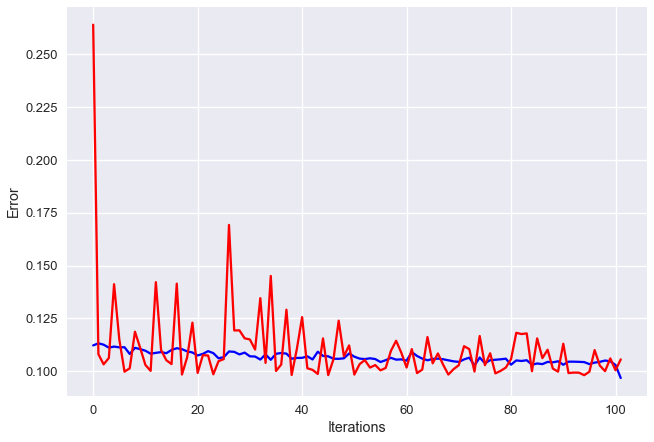

In [7]:
random.seed(0)

trainer = BackpropTrainer(net, dataset=ds_train)  # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)

line_train = plt.plot(err_train, 'b', err_val, 'r')
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')
plt.show()

In [8]:
res_train = net.activateOnDataset(ds_train).argmax(axis=1)
print(f'Error on train: {percentError(res_train, ds_train["target"].argmax(axis=1)):.2f} %')

res_test = net.activateOnDataset(ds_test).argmax(axis=1)
print(f'Error on train: {percentError(res_test, ds_test["target"].argmax(axis=1)):.2f} %')

Error on train: 52.10 %
Error on train: 46.04 %


## Поиск оптимального числа нейронов

In [30]:
def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):
# hidden_neurons_num -- массив размера h, содержащий количество нейронов, по которому предполагается провести перебор,
#   hidden_neurons_num = [50, 100, 200, 500, 700, 1000];
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на обучении;
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на контроле
    plt.figure()
    plt.plot(hidden_neurons_num, res_train_vec, label='train')
    plt.plot(hidden_neurons_num, res_test_vec, '-r', label='test')
    plt.legend(loc='best')
    plt.ylim((40, 60))


Num: 50 	50.49% vs 45.62%
Num: 100 	52.10% vs 46.04%
Num: 200 	50.49% vs 44.38%
Num: 500 	52.73% vs 50.62%
Num: 700 	51.03% vs 50.21%
Num: 1000 	50.31% vs 48.96%


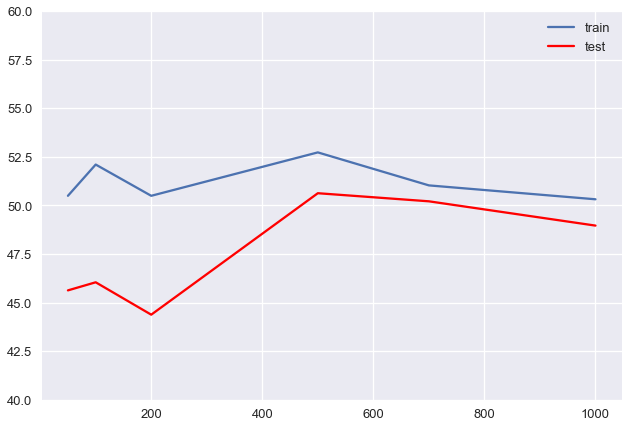

In [32]:
hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
res_train_vec, res_test_vec = [], []

for num in hidden_neurons_num:
    random.seed(0) # Зафиксируем seed для получения воспроизводимого результата
    np.random.seed(0)

    net_ = buildNetwork(ds_train.indim, num, ds_train.outdim, outclass=SoftmaxLayer)
    init_params_ = np.random.random((len(net_.params)))
    net_._setParameters(init_params_)

    trainer_ = BackpropTrainer(net_, dataset=ds_train)
    trainer_.trainUntilConvergence(maxEpochs=MAX_EPOCHS)

    res_train_ = net_.activateOnDataset(ds_train).argmax(axis=1)
    err_train = percentError(res_train_, ds_train["target"].argmax(axis=1))
    res_train_vec.append(err_train)

    res_test_ = net_.activateOnDataset(ds_test).argmax(axis=1)
    err_test = percentError(res_test_, ds_test["target"].argmax(axis=1))
    res_test_vec.append(err_test)
    print(f'Num: {num} \t{err_train:.2f}% vs {err_test:.2f}%')

plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec)
plt.show()

In [26]:
def write_answer_nn(optimal_neurons_num):
    with open("nnets_answer1.txt", "w") as fout:
        fout.write(str(optimal_neurons_num))

write_answer_nn(700)